In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame as DF
from collections import Counter
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import pickle
import math

## read data

In [2]:
# read data
data = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
test_pairs = test[['source', 'target']].values
data.head()

,video_id,uploader,age,category,length,views,rate,ratings,comments,1,...,11,12,13,14,15,16,17,18,19,20
0,LKh7zAJ4nwo,TheReceptionist,653.0,Entertainment,424.0,13021.0,4.34,1305.0,744.0,NaN,...,DjdA-5oKYFQ,vmdPOOd6cxI,uX81lMev6_o,NaN,W1Uo5DQTtzc,heqocRij5P0,2ZgXx72XmoE,1tUDzOp10pk,DH56yrIO5nI,E-3zXq_r4w0
1,7D0Mf4Kn4Xk,periurban,583.0,Music,201.0,6508.0,4.19,687.0,312.0,AvSK0qPw7EU,...,e2k0h6tPvGc,NaN,VKFqqoeMdjw,NSzrwv5MCwc,y3IDp2n7B48,N1lkLaLJHlc,NHB0a0xtLgU,Eq4hGkIqBGw,bdDskrr8jRY,JngPWhfCb2M
2,n1cEq1C8oqQ,Pipistrello,525.0,Comedy,125.0,1687.0,4.01,363.0,141.0,YfShxdbAJS8,...,eprHhmurMHg,yLup8wjbSIo,z5wDjq8o60c,bWlPSLUT-6U,bSPVayE0NhE,F2_5KOnSsfI,dsBTo5LExr0,gnpvEvuiFoQ,3nH5Tccz8EQ,sEqCkwPmQ_w
3,OHkEzL4Unck,ichannel,638.0,Comedy,299.0,8043.0,4.40,518.0,371.0,NaN,...,eyUSTmEUQRg,LQUV_XGzHmA,nfBfC8bif1Y,aiYwo5K0VWg,N4EYgXReBzM,FMuWYExDEJk,Ml2NaXU6gms,DVNwUKAuB3I,mDjwzhc8dQ0,NyC_0Z6zoUk
4,-boOvAGNKUc,mrpitifulband,639.0,Music,287.0,7548.0,4.48,606.0,386.0,JsdCu9T47iY,...,fmUwUURgsX0,eV2SdBITv8k,sf-Ym_pFP6U,0vhVZQEzgcU,lhWk9SXUjWI,geiABCqmQ84,dDhCZVQf9po,RZo5MisSTWo,saBmFpuwmKA,aVhSaa6aAOg


In [3]:
video_set = data['video_id'].values
video_list = data['video_id'].values.reshape(-1,1)

for i in range(1,21,1):
    video_set = np.concatenate((video_set,data[str(i)].values),axis=0) # concatenate vertically
    video_list = np.concatenate((video_list,data[str(i)].values.reshape(-1,1)),axis=1) # concatenate horizontally

In [4]:
# build hash map to speed up search
hashmap_video = {}; hashmap_cate = {}; hashmap_sim = {}; ind1=0; ind2=0
parent_video = data['video_id'].values
parent_video_set = set(parent_video)
for index, row in data.iterrows():
    hashmap_video[row['video_id']] = {'category': row['category'],'index':ind2}
    try:
        hashmap_cate[row['category']].append(row['video_id'])
    except:
        hashmap_cate[row['category']] = []
        hashmap_cate[row['category']].append(row['video_id'])
        hashmap_sim[row['category']] = ind1
        ind1 += 1
    ind2+=1

In [5]:
parent_edges = []

import math
for index0, row in enumerate(video_list):
    for i in range(20):
        try:
            math.isnan(row[i+1])
        except:
            if row[i+1] in parent_video_set:
                parent_edges.append((row[0], row[i+1]))

### spectral clustering test using onlyt the parents nodes

In [6]:
g_test = nx.DiGraph()
g_test.add_nodes_from(list(set(parent_video_set))[1:])
g_test.add_edges_from(parent_edges)

In [7]:
# L = nx.directed_laplacian_matrix(g_test)

In [8]:
# pickle.dump((w.real*1000000000).astype('int32'),open('w_small.p','wb'))
# pickle.dump((v.real*1000000000).astype('int32'),open('v_small.p','wb'))

In [9]:
w=pickle.load(open('w_small.p','rb'))/1000000000
v=pickle.load(open('v_small.p','rb'))/1000000000

In [10]:
index_range = np.array((np.where(np.logical_and(w>=0, w<1))))[0]
len(index_range)

11738

In [11]:
minmax = MinMaxScaler()
v1 = minmax.fit_transform(v[:,index_range].T).T

In [12]:
lda = TruncatedSVD(n_components=2, random_state=0)
XXX = lda.fit_transform(v1)

In [13]:
k=2
kmeans=KMeans(n_clusters=k)
result=kmeans.fit_predict(v1)

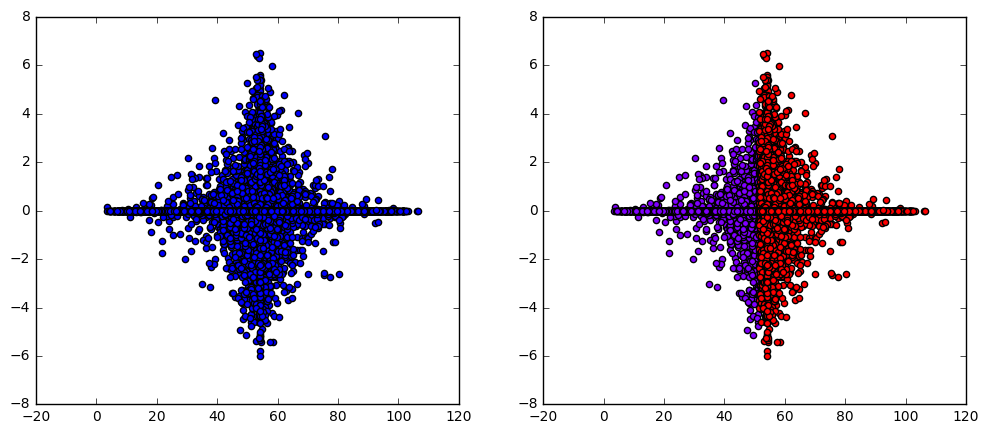

In [14]:
colors = cm.rainbow(np.linspace(0, 1, k))
fg,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].scatter(XXX[:,0],XXX[:,1])
for i in range(k):
    ax[1].scatter(XXX[result==i,0],XXX[result==i,1],c=colors[i])
plt.savefig('2 spectral clustering.png')
plt.show()

### benchmarking form undirected graph on test data

In [64]:
g= nx.Graph()
g.add_nodes_from(list(set(video_set))[1:])

In [65]:
edge_pairs1 = []
for row in video_list:
    for i in range(20):
        try:
            math.isnan(row[i+1])
        except:
            edge_pairs1.append((row[0], row[i+1]))
            
g.add_edges_from(edge_pairs1)

In [66]:
path_length_undirect=np.ones(99500)*100
ct=0
for index, pair in enumerate(test_pairs):
    try:
        path_length_undirect[index]=nx.shortest_path_length(g, source=pair[0], target=pair[1])
    except: path_length_undirect[index] = 200

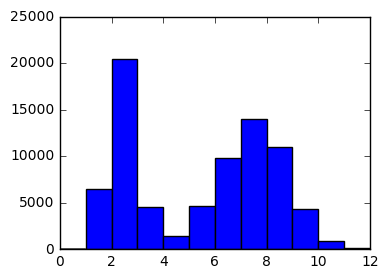

In [67]:
plt.figure(figsize=(4,3))
plt.hist(path_length_undirect,200)
plt.xlim(0,12)
plt.show()

In [68]:
output = np.zeros(99500)
for index, length in enumerate(path_length_undirect):
    if length <= 1 or length == 200:
        output[index]=1

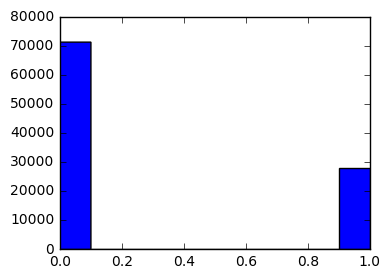

In [69]:
plt.figure(figsize=(4,3))
plt.hist(output)
plt.show()

### separate parent videos into to clusters

In [77]:
Counter(result)

Counter({0: 17030, 1: 9871})

In [78]:
hashmap_gtest = {}
for index, node in enumerate(g_test.nodes()):
    hashmap_gtest[node]=result[index]

In [79]:
clu0_edges = []
clu1_edges = []
# clu2_edges = []
clu0_nodes = []
clu1_nodes = []
# clu2_nodes = []

# form edge pair
import math
for index0, row in enumerate(video_list):
    if hashmap_gtest[row[0]] == 0:
        clu0_nodes.append(row[0])
        for i in range(20):
            try:
                math.isnan(row[i+1])
            except:
                clu0_edges.append((row[0], row[i+1]))
                clu0_nodes.append(row[i+1])
                
    elif hashmap_gtest[row[0]] == 1:
        clu1_nodes.append(row[0])
        for i in range(20):
            try:
                math.isnan(row[i+1])
            except:
                clu1_edges.append((row[0], row[i+1]))
                clu1_nodes.append(row[i+1])
                
#     else:
#         clu2_nodes.append(row[0])
#         for i in range(20):
#             try:
#                 math.isnan(row[i+1])
#             except:
#                 clu2_edges.append((row[0], row[i+1]))
#                 clu2_nodes.append(row[i+1])

In [80]:
g0=nx.DiGraph()
g0.add_nodes_from(list(set(clu0_nodes))[1:])
g0.add_edges_from(clu0_edges)
len(g0.nodes())

157716

In [81]:
g1=nx.DiGraph()
g1.add_nodes_from(list(set(clu1_nodes))[1:])
g1.add_edges_from(clu1_edges)
len(g1.nodes())

104607

In [61]:
# g2=nx.DiGraph()
# g2.add_nodes_from(list(set(clu2_nodes))[1:])
# g2.add_edges_from(clu2_edges)
# len(g2.nodes())

58110

In [82]:
start=time.time()
path_length_0=np.ones(99500)*100
path_length_1=np.ones(99500)*100
path_length_2=np.ones(99500)*100

for index, pair in enumerate(test_pairs):
    if output[index] != 1:
        try:
            path_length_0[index]=nx.shortest_path_length(g0, source=pair[0], target=pair[1])
        except: None
            
        try:
            path_length_1[index]=nx.shortest_path_length(g1, source=pair[0], target=pair[1]) 
        except: None
            
#         try:
#             path_length_2[index]=nx.shortest_path_length(g2, source=pair[0], target=pair[1])
#         except: None

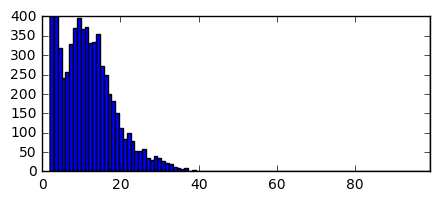

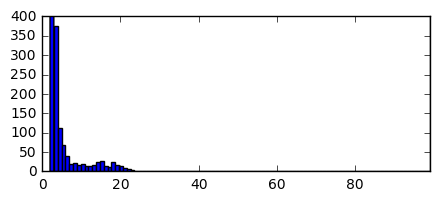

In [83]:
plt.figure(figsize=(5,2))
plt.hist(path_length_0,100)
plt.ylim(0,400)
plt.xlim(0,99)
plt.show()
plt.figure(figsize=(5,2))
plt.hist(path_length_1,100)
plt.ylim(0,400)
plt.xlim(0,99)
plt.show()
# plt.figure(figsize=(5,2))
# plt.hist(path_length_2,100)
# plt.ylim(0,400)
# plt.xlim(0,99)
# plt.show()

In [119]:
output2 = np.zeros(99500)
for index, length in enumerate(path_length_undirect):
    if length <= 4 or length == 200:
        output2[index]=1
        if 100> path_length_0[index] > 27 or 100> path_length_1[index] > 10:
            output2[index]=0

In [120]:
Counter(output2)

Counter({0.0: 44995, 1.0: 54505})

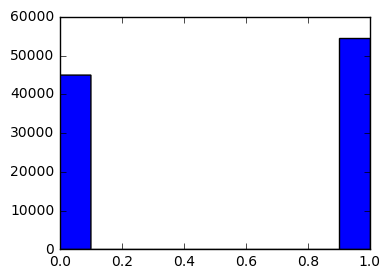

In [121]:
plt.figure(figsize=(4,3))
plt.hist(output2)
plt.show()

In [122]:
pd.concat((test['edge_id'],DF(output2.astype('int8'),columns=['edge_present'])),axis=1).to_csv('output.csv',index=False)

## This method achieved AUC of 0.92207